In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import durbin_watson
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import scipy.stats as stats
import matplotlib.pyplot as plt

In [32]:
ALPHA: float = 0.05

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


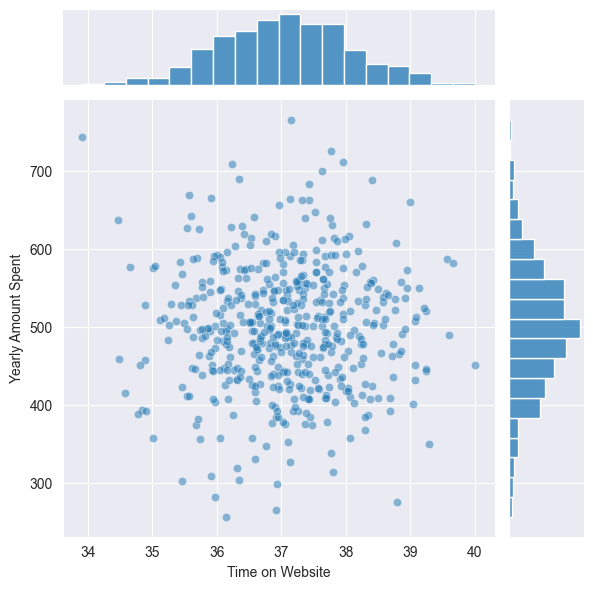

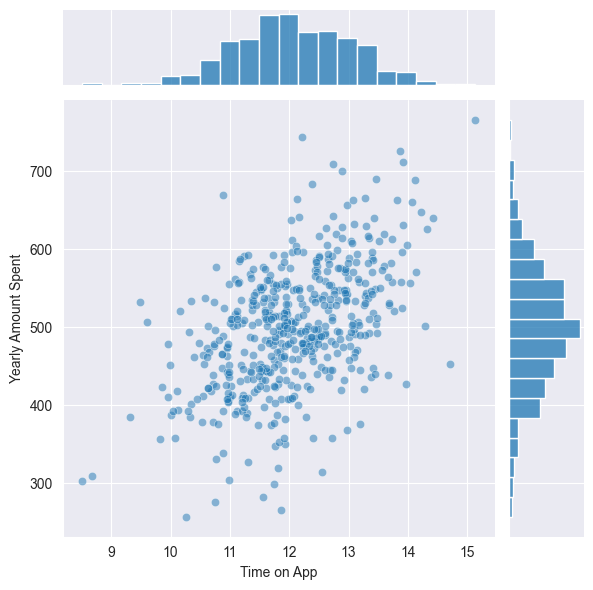

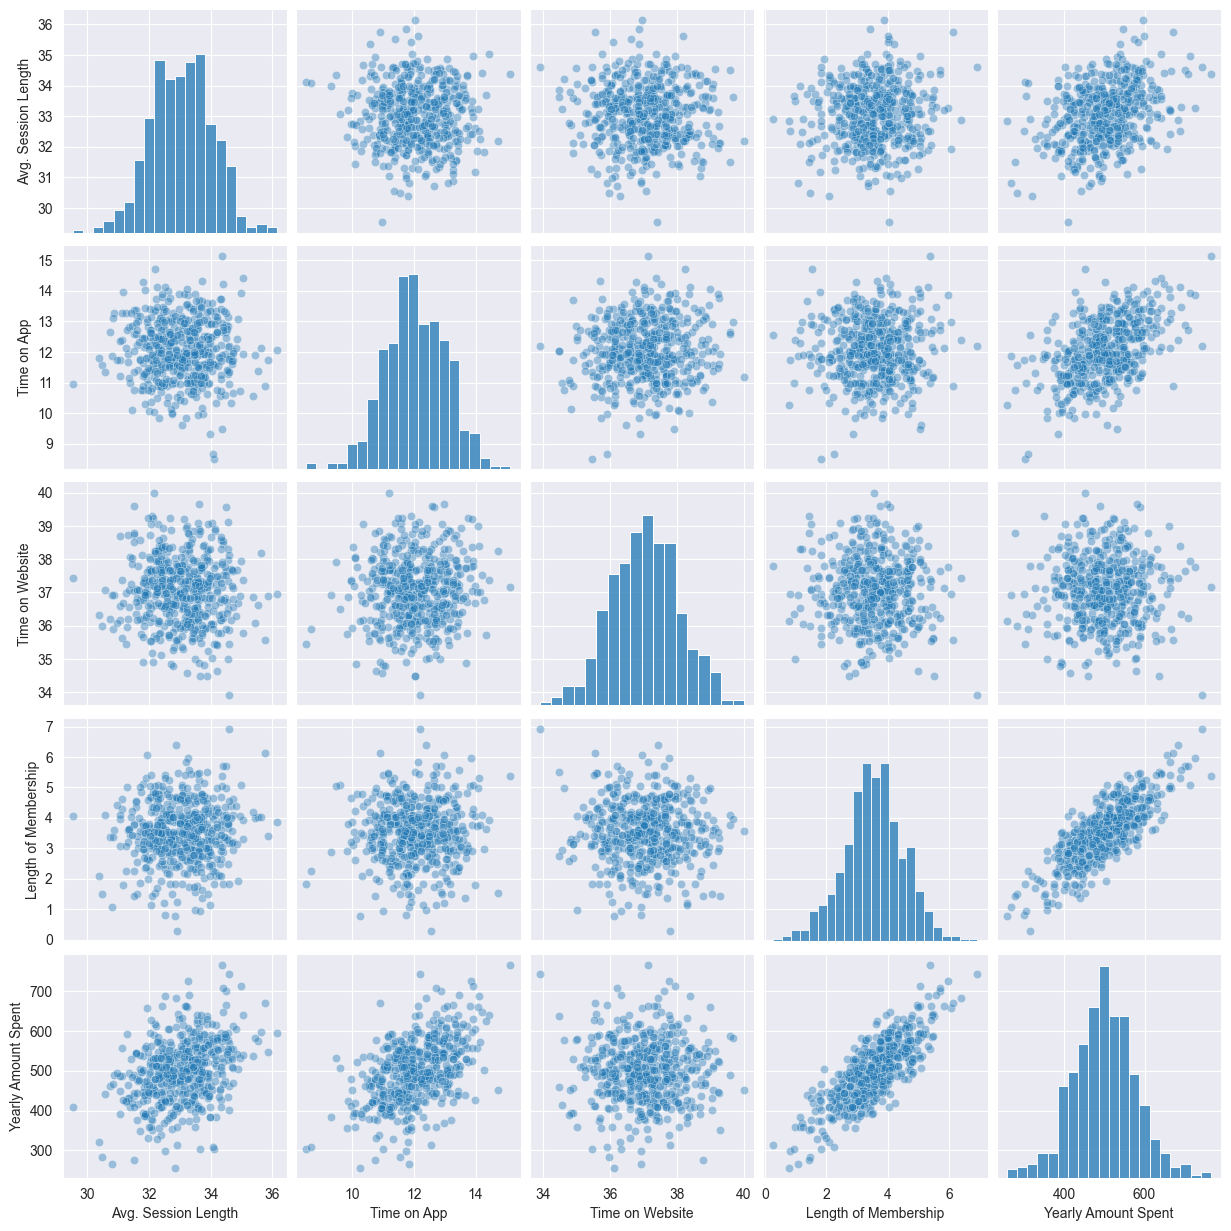

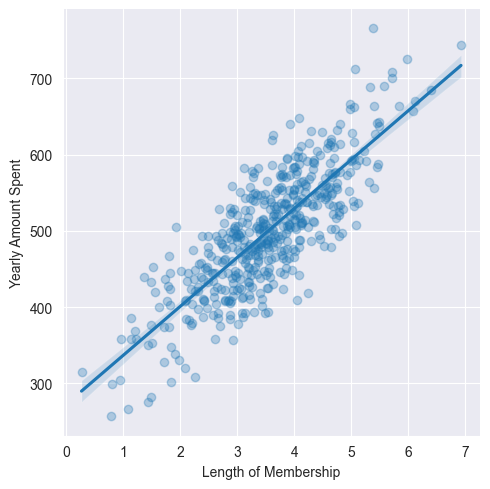

In [3]:
df = pd.read_csv('data/Ecommerce Customers')
df.head()
df.info()

#EDA

sns.jointplot(x='Time on Website', y='Yearly Amount Spent', data=df, alpha=0.5)
sns.jointplot(x='Time on App', y='Yearly Amount Spent', data=df, alpha=0.5)
sns.pairplot(df, kind='scatter', plot_kws={'alpha':0.4})

sns.lmplot(x='Length of Membership',
           y='Yearly Amount Spent',
           data=df,
           scatter_kws={'alpha':0.3})



In [4]:
X = df[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']]
y = df['Yearly Amount Spent']

# Split into TRAIN and TEST sets (X_train/X_test are inputs, y_train/y_test are true targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Fit a model on the TRAIN split
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [6]:
# Predictions on TRAIN and TEST
y_pred_train = linear_model.predict(X_train)  # model’s predictions for the TRAIN inputs
y_pred_test  = linear_model.predict(X_test)   # model’s predictions for the TEST inputs

In [7]:
# Compare predictions to the corresponding true targets

# (y_train vs y_pred_train) for training diagnostics
mean_absolute_error_train = metrics.mean_absolute_error(y_train, y_pred_train)
mean_squared_error_train = np.mean((y_train - y_pred_train)**2)
root_mean_squared_error_train = np.sqrt(np.mean((y_train - y_pred_train)**2))
r2_train = metrics.r2_score(y_train, y_pred_train)

# (y_test vs y_pred_test) for generalization performance
mean_absolute_error_test = metrics.mean_absolute_error(y_test, y_pred_test)
mean_squared_error_test = metrics.mean_squared_error(y_test, y_pred_test)
root_mean_squared_error_test = np.sqrt(np.mean((y_test - y_pred_test)**2))
r2_test = metrics.r2_score(y_test, y_pred_test)

print("Training set:")
print("  y_train                             =", y_train.shape, "(true targets for training rows)")
print("  y_pred_train                        =", y_pred_train.shape, "(predicted targets for training rows)")
print("  MAE_train (Mean Absolute Error)     =", mean_absolute_error_train)
print("  MSE_train (Mean Squared Error)      =", mean_squared_error_train)
print("  RMSE_train (Root Mean Squared Error)=", root_mean_squared_error_train)
print("  R2_train                            =", r2_train)

print("\nTest set:")
print("  y_test                              =", y_test.shape, "(true targets for test rows)")
print("  y_pred_test                         =", y_pred_test.shape, "(predicted targets for test rows)")
print("  MAE_test (Mean Absolute Error)      =", mean_absolute_error_test)
print("  MSE_test (Mean Squared Error)       =", mean_squared_error_test)
print("  RMSE_test (Root Mean Squared Error) =", root_mean_squared_error_test)
print("  R2_test                             =", r2_test)

Training set:
  y_train                             = (350,) (true targets for training rows)
  y_pred_train                        = (350,) (predicted targets for training rows)
  MAE_train (Mean Absolute Error)     = 7.664695205735474
  MSE_train (Mean Squared Error)      = 96.43694988813478
  RMSE_train (Root Mean Squared Error)= 9.820231661632773
  R2_train                            = 0.9854085989105928

Test set:
  y_test                              = (150,) (true targets for test rows)
  y_pred_test                         = (150,) (predicted targets for test rows)
  MAE_test (Mean Absolute Error)      = 8.426091641432116
  MSE_test (Mean Squared Error)       = 103.91554136503333
  RMSE_test (Root Mean Squared Error) = 10.193897260863155
  R2_test                             = 0.9808757641125855


In [8]:
# Train Residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

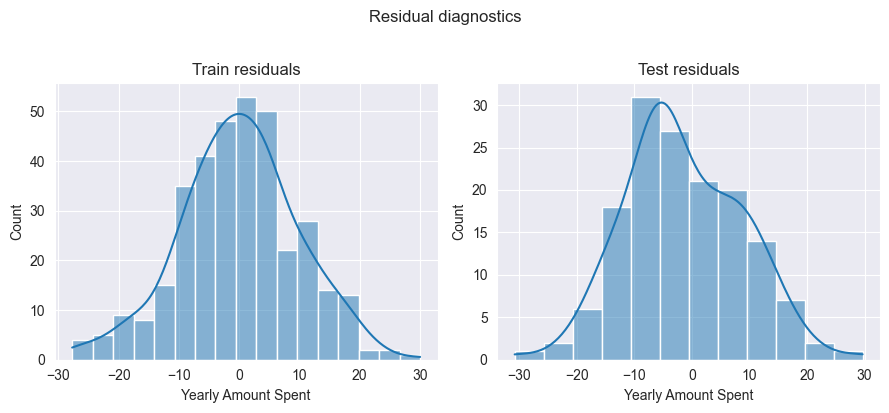

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
sns.histplot(residuals_train, ax=ax1, kde=True); ax1.set_title("Train residuals")
sns.histplot(residuals_test,  ax=ax2, kde=True); ax2.set_title("Test residuals")
fig.suptitle("Residual diagnostics", y=1.02)  # overall figure title
plt.tight_layout()

Mean_train & Mean_test =  -0.0 -1.44712


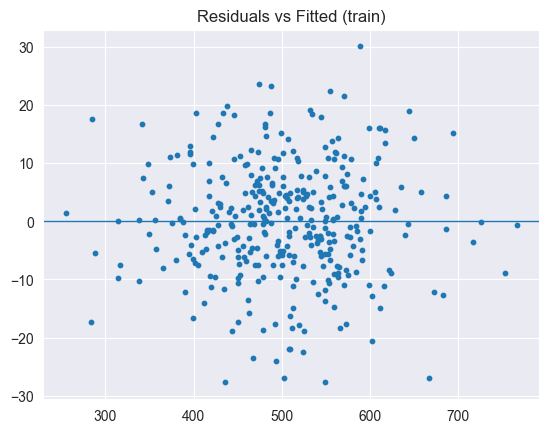

In [10]:
# Diagnostic Checklist

# Mean = 0
print('Mean_train & Mean_test = ',round(residuals_train.mean(),6), round(residuals_test.mean(),6))

# Homoscedasticity (constant variance) – residuals vs fitted should look like random fuzz (no funnel).
plt.scatter(y_pred_train, residuals_train, s=10); plt.axhline(0, lw=1)
plt.title("Residuals vs Fitted (train)"); plt.show()

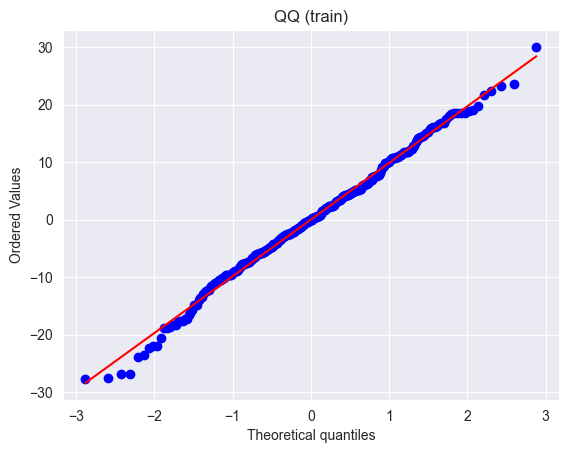

In [11]:
#QQ plot (QQ is stricter):
stats.probplot(residuals_train, dist="norm", plot=plt); plt.title("QQ (train)"); plt.show()

In [12]:
# Independence / autocorrelation (esp. time series):
# ~2 is good; <1 or >3 suggests autocorrelation

print("Durbin–Watson (train):", durbin_watson(residuals_train))

Durbin–Watson (train): 2.0244255139997214


In [33]:
# Test Statistic (F-stat) using the TRAIN set

n = len(y_train)
p_params = X_train.shape[1] + 1                 # features + intercept

df1 = p_params - 1
df2 = n - p_params

F_statistic_overall = (r2_train / (p_params - 1)) / ((1 - r2_train) / (n - p_params))
p_value = stats.f.sf(F_statistic_overall, df1, df2)  # survival function = 1 - CDF

print('F_statistic_overall  =',F_statistic_overall)
print('p-value              =', round(p_value,5))              # ~ 0.0 (very small)
print("decision:", "REJECT H0" if p_value < ALPHA else "FAIL TO REJECT H0")

F_statistic_overall  = 5824.765636641946
p-value              = 0.0
decision: REJECT H0


### Method 'evaluate_regression'

In [15]:

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

def evaluate_regression(X_train, X_test, y_train, y_test, model, name=None):
    # Fit (assumes model is unfitted; remove fit() if you already fit)
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Metrics
    mae_tr  = mean_absolute_error(y_train, y_pred_train)
    mse_tr  = mean_squared_error(y_train, y_pred_train)
    rmse_tr = np.sqrt(mse_tr)
    r2_tr   = r2_score(y_train, y_pred_train)

    mae_te  = mean_absolute_error(y_test, y_pred_test)
    mse_te  = mean_squared_error(y_test, y_pred_test)
    rmse_te = np.sqrt(mse_te)
    r2_te   = r2_score(y_test, y_pred_test)

    # Baseline
    baseline = DummyRegressor(strategy="mean").fit(X_train, y_train)
    yb = baseline.predict(X_test)
    rmse_base = np.sqrt(mean_squared_error(y_test, yb))

    # Normalized error
    y_std = np.std(y_test, ddof=1) if len(y_test) > 1 else np.nan
    nrmse = rmse_te / y_std if y_std and not np.isnan(y_std) else np.nan

    # Gaps & lifts
    rmse_gap = (rmse_te - rmse_tr) / rmse_tr if rmse_tr != 0 else np.inf
    lift_vs_base = (rmse_base - rmse_te) / rmse_base if rmse_base != 0 else np.nan

    # Print summary
    if name: print(f"\n=== {name} ===")
    print("Train:")
    print(f"  MAE={mae_tr:.4f}  MSE={mse_tr:.4f}  RMSE={rmse_tr:.4f}  R2={r2_tr:.6f}")
    print("Test:")
    print(f"  MAE={mae_te:.4f}  MSE={mse_te:.4f}  RMSE={rmse_te:.4f}  R2={r2_te:.6f}")
    print(f"Baseline RMSE (mean predictor) = {rmse_base:.4f}")
    if not np.isnan(nrmse): print(f"nRMSE = RMSE_test / std(y_test) = {nrmse:.3f}")
    print(f"RMSE gap (test vs train) = {rmse_gap*100:.1f}%")
    print(f"Lift vs baseline (RMSE reduction) = {lift_vs_base*100:.1f}%")

    # Interpretation (simple rules)
    verdicts = []
    if rmse_gap <= 0.10: verdicts.append("Generalization looks healthy (RMSE gap ≤ 10%).")
    elif rmse_gap <= 0.30: verdicts.append("Some overfit risk (RMSE gap 10–30%). Check residuals/regularize.")
    else: verdicts.append("Likely overfitting/leakage (RMSE gap > 30%). Investigate splits and preprocessing.")

    if r2_te >= 0.9: verdicts.append("R²_test is excellent.")
    elif r2_te >= 0.7: verdicts.append("R²_test is strong.")
    elif r2_te >= 0.4: verdicts.append("R²_test is moderate; may be fine depending on noise.")
    else: verdicts.append("R²_test is low; consider more features or nonlinearities.")

    if lift_vs_base >= 0.3: verdicts.append("Beating baseline by ≥30% RMSE — strong improvement.")
    elif lift_vs_base >= 0.1: verdicts.append("Beating baseline by 10–30% — decent improvement.")
    else: verdicts.append("Little gain over baseline — revisit features/target prep.")

    if not np.isnan(nrmse):
        if nrmse < 0.5: verdicts.append("nRMSE < 0.5 — errors small vs target variability.")
        elif nrmse < 1.0: verdicts.append("nRMSE 0.5–1.0 — errors moderate.")
        else: verdicts.append("nRMSE ≥ 1.0 — errors large relative to target spread.")

    print("\nInterpretation:")
    for v in verdicts:
        print(" - " + v)

    return {
        "mae_train": mae_tr, "mse_train": mse_tr, "rmse_train": rmse_tr, "r2_train": r2_tr,
        "mae_test": mae_te, "mse_test": mse_te, "rmse_test": rmse_te, "r2_test": r2_te,
        "rmse_gap": rmse_gap, "baseline_rmse": rmse_base, "lift_vs_baseline": lift_vs_base, "nrmse": nrmse
    }


In [16]:
evaluate_regression(X_train, X_test, y_train, y_test, model=linear_model)

Train:
  MAE=7.6647  MSE=96.4369  RMSE=9.8202  R2=0.985409
Test:
  MAE=8.4261  MSE=103.9155  RMSE=10.1939  R2=0.980876
Baseline RMSE (mean predictor) = 74.4121
nRMSE = RMSE_test / std(y_test) = 0.138
RMSE gap (test vs train) = 3.8%
Lift vs baseline (RMSE reduction) = 86.3%

Interpretation:
 - Generalization looks healthy (RMSE gap ≤ 10%).
 - R²_test is excellent.
 - Beating baseline by ≥30% RMSE — strong improvement.
 - nRMSE < 0.5 — errors small vs target variability.


{'mae_train': 7.664695205735474,
 'mse_train': 96.43694988813478,
 'rmse_train': np.float64(9.820231661632773),
 'r2_train': 0.9854085989105928,
 'mae_test': 8.426091641432116,
 'mse_test': 103.91554136503333,
 'rmse_test': np.float64(10.193897260863155),
 'r2_test': 0.9808757641125855,
 'rmse_gap': np.float64(0.03805058903959234),
 'baseline_rmse': np.float64(74.41213646198915),
 'lift_vs_baseline': np.float64(0.8630075986855941),
 'nrmse': np.float64(0.13782866531131469)}

In [17]:
#“We can predict yearly spend accurately from just four usage stats: session length, time on the app, time on the website, and membership length.”


### Test The Model

In [18]:

#1) Train the model (as you did)
#2) Predict for a new customer
#Make a one-row DataFrame with the same column names and units as your training data.

new_customer = pd.DataFrame([{
    "Avg. Session Length": 33.2,
    "Time on App": 12.5,          # same unit as training (e.g., minutes)
    "Time on Website": 9.8,
    "Length of Membership": 3.6   # same unit as training (e.g., years)
}])

predicted_spend = linear_model.predict(new_customer)[0]
print(f"Predicted Yearly Amount Spent: {predicted_spend:.2f}")

Predicted Yearly Amount Spent: 512.38
